In [3]:
import numpy as np
import imutils
import random

from utils.augmenters import *
from keras import layers
from keras import ops
import cv2

import tensorflow as tf
import keras

import matplotlib.pyplot as plt

tf.__version__, keras.__version__

('2.15.0', '3.0.0')

In [4]:
num_classes = 33
input_shape = (32,32,1)
validation_split = 0.2

(32, 32, 3)


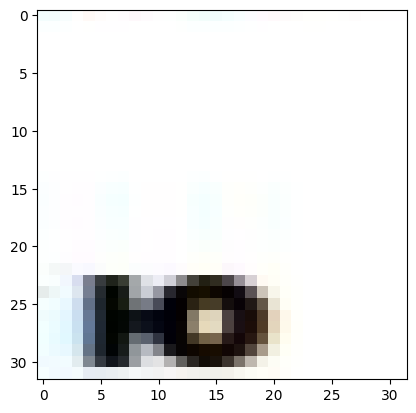

In [46]:
let = cv2.imread('data/letterlist.jpg', 1)
let = let[15:780,:]
num_letters = 33
num_fonts = 21


def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [47]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(8)
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(3, 65, 0)

693
1117
1763
2814
4490
7161
11452
18331
693
1099
1727


In [48]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

num_train_samples = int(len(x_data) * (1 - validation_split))
num_val_samples = len(x_data) - num_train_samples
x_train, x_val = np.split(x_data, [num_train_samples])
y_train, y_val = np.split(y_data, [num_train_samples])

test_x_data = np.array(test_aug.images)
test_x_data = test_x_data.reshape(*test_x_data.shape,1)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

# x_train = np.concatenate((x_train,)*3, axis=-1)
# x_val = np.concatenate((x_val,)*3, axis=-1)
# test_x_data = np.concatenate((test_x_data,)*3, axis=-1)

x_train.shape, x_val.shape, test_x_data.shape

((23432, 32, 32, 3, 1), (5858, 32, 32, 3, 1), (2788, 32, 32, 3, 1))

In [70]:
from keras.applications import MobileNetV3Large

inputs = keras.Input(shape=input_shape )
rn = MobileNetV3Large(
    include_top=False,
    input_shape=((*input_shape[:2], 3)),
    classifier_activation = None
)
rn

/home/main/.local/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<Functional name=MobilenetV3large, built=True>

In [71]:
rn.trainable = False
dense = layers.Flatten()(rn.output)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = layers.Dense(num_classes, activation='softmax')(dense)
model = keras.Model(inputs=rn.input, outputs=outputs)
model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 32, 32, 3) │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ rescaling           │ (None, 32, 32, 3) │       0 │ input_layer_14[0][0] │
│ (Rescaling)         │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv (Conv2D)       │ (None, 16, 16,    │     432 │ rescaling[0][0]      │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv_bn             │ (None, 16, 16,    │      64 │ conv[0][0]           │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ add (Add)           │ (None, 16, 16,    │       0 │ conv_bn[0][0]        │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │       0 │ add[0][0]            │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply_1          │ (None, 16, 16,    │       0 │ re_lu[0][0]          │
│ (Multiply)          │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ multiply (Multiply) │ (None, 16, 16,    │       0 │ conv_bn[0][0],       │
│                     │ 16)               │         │ multiply_1[0][0]     │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │     144 │ multiply[0][0]       │
│ (DepthwiseConv2D)   │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_dept… │ (None, 16, 16,    │      64 │ expanded_conv_depth… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │       0 │ expanded_conv_depth… │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │     256 │ re_lu_1[0][0]        │
│ (Conv2D)            │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_proj… │ (None, 16, 16,    │      64 │ expanded_conv_proje… │
│ (BatchNormalizatio… │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_add   │ (None, 16, 16,    │       0 │ multiply[0][0],      │
│ (Add)               │ 16)               │         │ expanded_conv_proje… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │   1,024 │ expanded_conv_add[0… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ expanded_conv_1_ex… │ (None, 16, 16,    │     256 │ expanded_conv_1_exp… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │       0 │ expanded_conv_1_exp

 Total params: 4,645,025 (17.72 MB)

 Trainable params: 1,648,673 (6.29 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [79]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-4,
                              patience=5, min_lr=1e-8)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=7, start_from_epoch=30)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")
checkpoint_filepath = f"tmp/mobilenet_checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_categorical_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

callbacks = [reduce_lr, early_stop, tensorboard, checkpoint_callback]

model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

his = model.fit(x_train, y_train, 
          batch_size=32, 
          epochs=200, 
          validation_data=(x_val, y_val), 
          shuffle=True,
          callbacks= callbacks
          )

Epoch 1/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - categorical_accuracy: 0.5809 - loss: 1.3256 - val_categorical_accuracy: 0.4554 - val_loss: 1.8898 - learning_rate: 0.0010
Epoch 2/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.5941 - loss: 1.2773 - val_categorical_accuracy: 0.3907 - val_loss: 2.1581 - learning_rate: 0.0010
Epoch 3/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.5920 - loss: 1.2900 - val_categorical_accuracy: 0.4348 - val_loss: 1.9545 - learning_rate: 0.0010
Epoch 4/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.5880 - loss: 1.2920 - val_categorical_accuracy: 0.3511 - val_loss: 2.3570 - learning_rate: 0.0010
Epoch 5/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.5946 - loss: 1.2808 - val_categorical_accuracy: 0.4039 - val_loss: 2.2024 - learning_rate: 0.0010
Epoch 6/200
733/733 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.6099 - loss: 1.2272 - val_categori

In [80]:
model.evaluate(test_x_data, test_y_data)

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - categorical_accuracy: 0.7372 - loss: 1.0049


[1.3904187679290771, 0.6527976989746094]

In [81]:
model.predict(test_x_data), len(test_x_data)

88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


(array([[9.9738556e-01, 8.1937062e-05, 1.4090031e-07, ..., 5.7296390e-33,
         2.0475732e-29, 8.1266105e-10],
        [1.3076216e-04, 9.8575020e-01, 1.9944217e-07, ..., 1.4301833e-21,
         4.2524805e-19, 1.7808484e-11],
        [3.3747531e-03, 1.9998010e-03, 6.2464446e-01, ..., 2.5340498e-21,
         8.9542836e-22, 4.9159178e-19],
        ...,
        [1.6597413e-02, 1.3097700e-04, 5.3186798e-03, ..., 4.0356144e-06,
         3.8313095e-09, 5.5256664e-06],
        [1.3665462e-01, 4.4369712e-04, 7.1619069e-03, ..., 7.9939628e-06,
         1.1952144e-06, 1.3684162e-03],
        [2.5780049e-21, 3.9710284e-16, 9.4245197e-06, ..., 1.1048176e-13,
         1.3918736e-24, 2.0238711e-03]], dtype=float32),
 2788)

In [82]:
model.save('models/mobileNet_model.keras')

In [84]:
keras.utils.plot_model(model, to_file='models/mobileNet_model.jpg')

"dot" with args ['-Tjpg', '/tmp/tmpf_x9d3s2'] returned code: -6

stdout, stderr:
 b''
b"newtrap: Trapezoid-table overflow 5381\ndot: trapezoid.c:84: newtrap: Assertion `0' failed.\n"


AssertionError: "dot" with args ['-Tjpg', '/tmp/tmpf_x9d3s2'] returned code: -6

In [85]:
import tensorflow.keras.backend as K

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 4,645,025
Trainable params: 1,648,673
Non-trainable params: 2,996,352
